# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Reading and Preprocessing the Data

In [3]:
df = pd.read_excel("/kaggle/input/yahoo-finance-dataset-2018-2023/yahoo_data.xlsx")
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,
2023-04-28,33797.43,34104.56,33728.40,34098.16,34098.16,354310000
2023-04-27,33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2023-04-26,33596.34,33645.83,33235.85,33301.87,33301.87,321170000
2023-04-25,33828.34,33875.49,33525.39,33530.83,33530.83,297880000
2023-04-24,33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [5]:
print(df.isnull().sum())

Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2023-04-28 to 2018-05-01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         1258 non-null   float64
 1   High         1258 non-null   float64
 2   Low          1258 non-null   float64
 3   Close*       1258 non-null   float64
 4   Adj Close**  1258 non-null   float64
 5   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


# Data Visualization

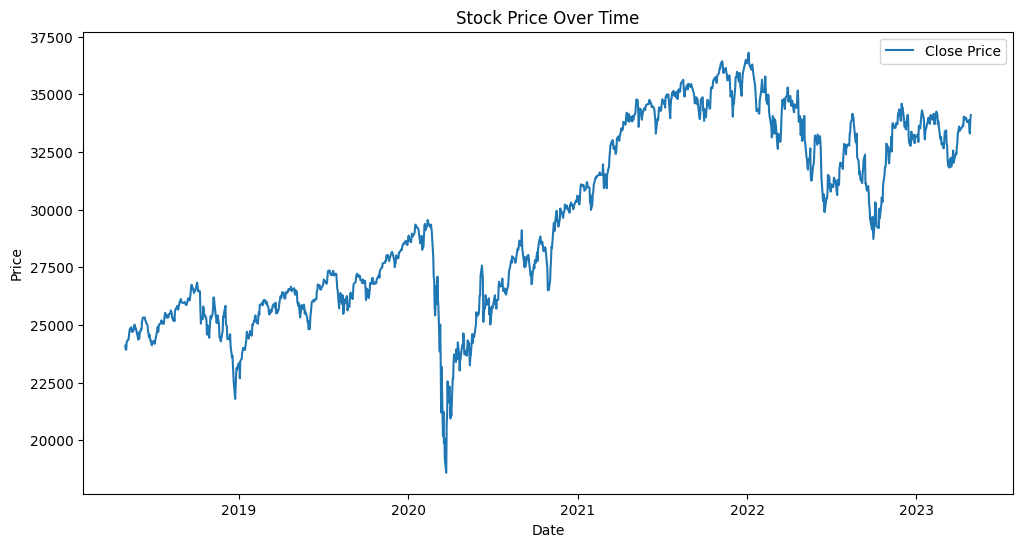

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['Adj Close**'], label='Close Price')
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

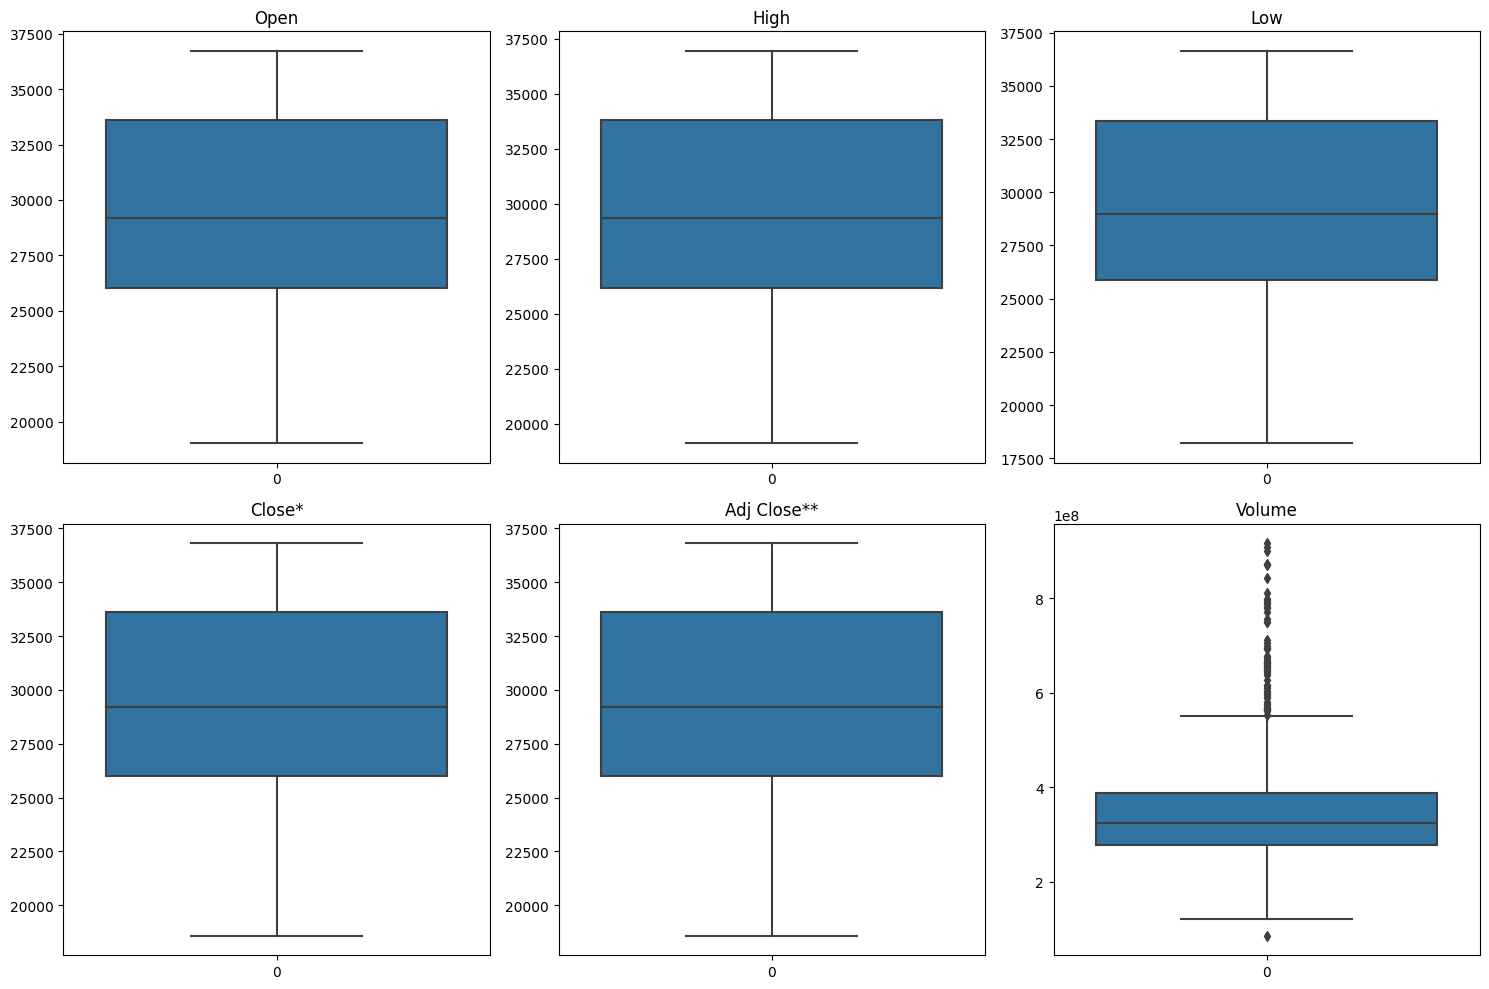

In [8]:
num_cols = 3
num_features = len(df.columns)
num_rows = math.ceil(num_features / num_cols)

fig = plt.figure(figsize=(15, num_rows * 5))

for i, x in enumerate(df.columns, start=1):
    plt.subplot(num_rows, num_cols, i)
    ax = sns.boxplot(df[x])
    ax.set(xlabel=None)
    plt.title(str(x), loc='center')
    plt.xlabel(None)
    plt.ylabel(None)

plt.tight_layout()
plt.show()

# Time Series Model

## Checking if the Data is Stationary

In [9]:
from statsmodels.tsa.stattools import adfuller

# Extract the 'Close' column as a series
close_series = df['Adj Close**']

# Run ADF test
def check_stationarity(series):
    result = adfuller(series.dropna())  # Drop NaN values if any
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

check_stationarity(close_series)

ADF Statistic: -1.420441252350837
p-value: 0.5724380460701348
The series is not stationary.


## Scaling the Data

In [10]:
scaler = MinMaxScaler()
df['Adj Close**'] = scaler.fit_transform(df[['Adj Close**']])

## Train-Test Split

In [11]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back)])
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# Extract the feature column
adj_close_values = df['Adj Close**'].values  

# Create dataset with look_back window
X, Y = create_dataset(adj_close_values, look_back=30)

# Split dataset into training and testing sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Reshaping the Data for the LSTM Model

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## Long Short-Term Memory (LSTM) Model

In [13]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(30, 1)))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(trainX, trainY, epochs=100, batch_size=32)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2284
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0086
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

# Prediction and Result

In [14]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [15]:
rmse = np.sqrt(mean_squared_error(testY, testPredict))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 286.7900399156372


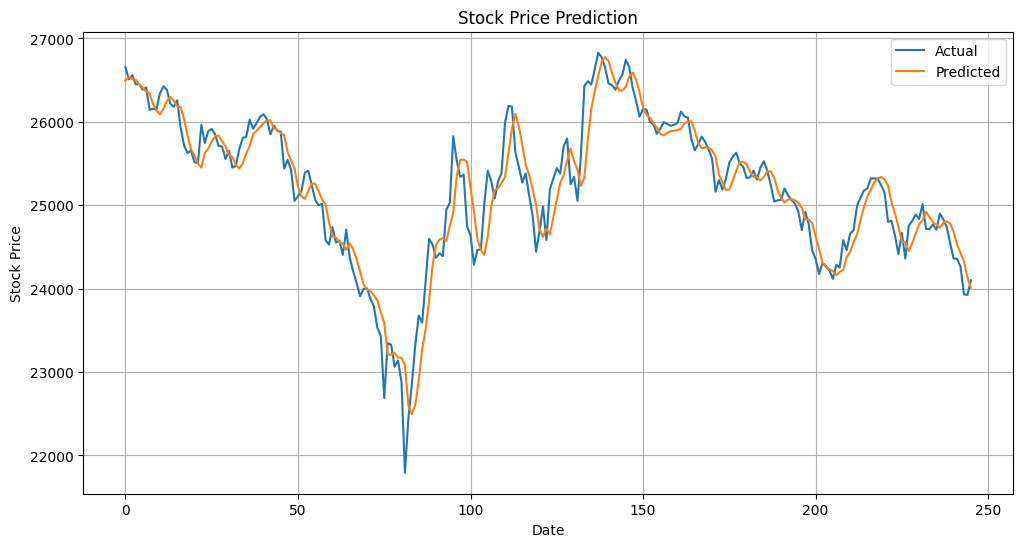

In [16]:
plt.figure(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction")
plt.plot(testY, label='Actual')
plt.plot(testPredict, label='Predicted')
plt.grid(True)
plt.legend()
plt.show()